# Project 4: Optimizations on the Ising Simulation

## I. Introduction

It took me about half a day to run the simulations for Project 3. This was surprisingly slow, so I wanted to know if there was any way to improve the speed of the simulation. I looked around on the internet, and I found two ways. The first one used some compiler (numba, cython) to compile the code faster, while the second one used torch. I found the second one interesting, so I decided to give it a try.

The result in the tutorial was impressive. The author was able to get the simulation done in just 3 minutes.
https://youtu.be/ykoEwJ7PvNw?si=Ejv9FBr3p4KUyos9


The idea was, if we store our data in the right way, we can compute things simultaneously. We can throw this on a GPU, and it should run much faster. Sadly however, running on the MPS on my Macbook was slower compared to running on the CPU, so every thing below was run on the CPU. Nevertheless, I was still able to speed up the code quite significantly.

In [1]:
# IMPORTS
import numpy as np
import torch
from torch.nn.functional import conv2d, pad
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# CHOOSING DEVICE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

## II. Building our simulation
We first try to write all the functions separately, then we will later make a class and put it all together.

### 1. Creating the lattices
To start with, let's define a function that we can use to create our lattice. Our approach is to compute a lot of things simultaneously, so we will create all the lattices that we need at the same time.

In [3]:
# Pick a value for the size of the array
N = 32
# Let's say at each point we want to create 300 simulations, and we want to do it for 100 values of T
n_sims = 30
n_temps = 1
def create_lattices(arr_size, n_sims, n_temps):
	"""
	This will create an array with 1 and -1 of the following shape
		[n_temps, n_sims, arr_size, arr_size]
	where
	- The n_temps is equal to the number of temperatures
	- The n_sims is equal to the number of simulations.
	- The arr_size x arr_size corresponds to the size of the 2D array.
	This is the initial lattices of our simulation.
	"""
	return torch.stack([
			torch.stack([
				torch.randint(low=0, high=2, size=(arr_size, arr_size), dtype=torch.float32) * 2 - 1
				for _ in range(n_sims)
			])
			for _ in range(n_temps)
	]).to(DEVICE)

lattices = create_lattices(N, n_sims, n_temps)
lattices.shape

torch.Size([1, 30, 32, 32])

### 2. Computing the energy array
A crucial part of our simulation is to compute the energy array. For each lattice, we will try to compute another N x N array, where each value is the interaction energy of the magnet at that site with its neighbour. To compute this for all lattices at once, we will use PyTorch's conv2d. We first need to build a kernel

In [180]:
# Building the kernel
kernel = torch.tensor(
	[[0, 1, 0],
	 [1, 0, 1],
	 [0, 1, 0]], dtype=torch.float32
).unsqueeze(dim=0).unsqueeze(dim=0).to(DEVICE)

kernel.shape

torch.Size([1, 1, 3, 3])

We see that this kernel will pick out all of the neighbours of any given magnet. From here, we can implement our create_energy_arr function

In [4]:
def create_energy_arr(lattices):
	"""
	This will create an array of the interaction energy of each magnet with its neighbour for all lattices. Its shape will be
		[n_temps, n_sims, arr_size, arr_size]
	"""
	# To do this, we create a kernel and do the convolution.
	arr_size = lattices.shape[-1]
	kernel = torch.tensor(
		[[0, 1, 0],
   		 [1, 0, 1],
		 [0, 1, 0]], dtype=torch.float32
	).unsqueeze(dim=0).unsqueeze(dim=0).to(DEVICE)
	# To convolve, we need to reshape our lattices array into [n_temps * n_sims, 1, arr_size, arr_size]
	reshape_lattices = lattices.view(-1, 1, arr_size, arr_size)
	energy_arr = -reshape_lattices * conv2d(pad(reshape_lattices, pad=(1, 1, 1, 1), mode='circular'), kernel)
	# After that, we convert it back into the original shape
	return energy_arr.view(lattices.shape)

energy_arr = create_energy_arr(lattices)
energy_arr.shape

torch.Size([1, 30, 32, 32])

### 3. Implementing the metropolis algorithm
The next step is to implement our metropolis algorithm. There are several ways to do this, with their own pros and cons, and we will explore some of them.


#### a. Flipping multiple cells at a time
The first approach is going to be the fastest one, since we are grouping all the steps together. To flip multiple cells at the same time, we choose a group of cells that form a checkerboard pattern, so that we don't choose any two cells that are next to each other. We can go ahead and implement our metropolis algorithm as follow

In [5]:
def metropolis(lattices, temperatures, n_steps):
	"""
	Do the metropolis algorithm.
	Return the energies and the magnetization of each step
	"""
	arr_size, n_sims = lattices.shape[-1], lattices.shape[1]
	energies = []
	magnetizations = []
	betas = (
        torch.vstack([1 / temperatures for _ in range(n_sims)]).T
    ).reshape([-1, n_sims, 1, 1]).to(DEVICE)

	for _ in tqdm(range(n_steps), desc="Loading..."):
		i = np.random.randint(0, 2)
		j = np.random.randint(0, 2)
		energy_arr = create_energy_arr(lattices)
		energies.append(energy_arr.sum(axis=(2, 3)) / 2 / arr_size**2)
		magnetizations.append(torch.abs(lattices.sum(axis=(2, 3))) / arr_size**2)
		delta_E = -2 * energy_arr
		probs = torch.exp(-betas * delta_E)
		flip_arr = (delta_E > 0) * (torch.rand(delta_E.shape).to(DEVICE) < probs) + (delta_E <= 0)
		lattices[..., i::2, j::2][flip_arr[..., i::2, j::2]] *= -1
	return torch.stack(energies), torch.stack(magnetizations)

Let's go ahead and try running this with one value of temperature (way below Tc)

In [187]:
test_lattices = create_lattices(32, 300, 1)
temperatures = torch.linspace(1, 1, 1)
energies, magnetizations = metropolis(test_lattices, temperatures, 10000)
energies.shape, magnetizations.shape

Loading...: 100%|██████████| 10000/10000 [00:27<00:00, 361.78it/s]


(torch.Size([10000, 1, 300]), torch.Size([10000, 1, 300]))

Let's plot the magnetization of one of the simuluation over the steps to see how our system evolves

tensor(1.)


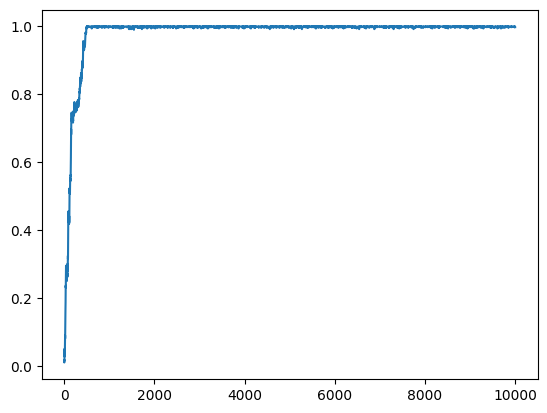

In [188]:
one_specific_simul = magnetizations[:, 0, 0]
print(torch.max(one_specific_simul))
plt.plot(range(len(one_specific_simul)), one_specific_simul.cpu())
plt.show()

Looks like it converged to M = 1. That's great! How about we look at another one

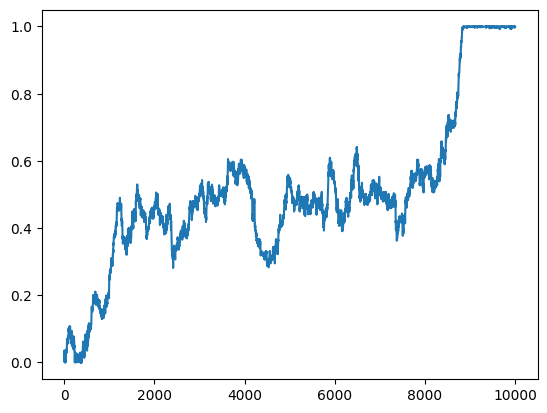

In [198]:
another_specific_simul = magnetizations[:, 0, 26]
plt.plot(range(len(another_specific_simul)), another_specific_simul.cpu())
plt.show()

This one still converged, but it's much closer than we would like. If we look at yet another one

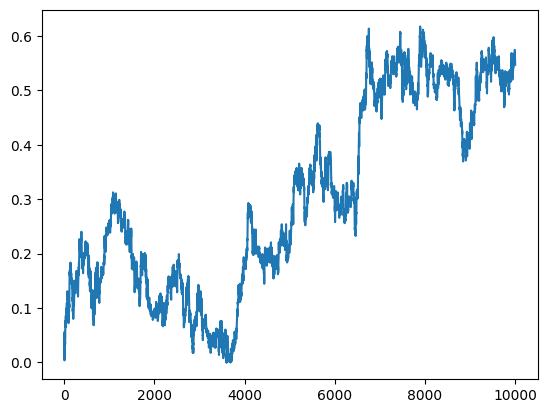

In [191]:
other_specific_simul = magnetizations[:, 0, -1]
plt.plot(range(len(other_specific_simul)), other_specific_simul.cpu())
plt.show()

Uh oh... This one did not converge to a stable state at all! If we make a histogram of the average value of M over all of our simulations, we will see that a significant fraction of our simulations did not converge, enough though we ran for 10,000 steps (much more than in project 3)

In [199]:
mean_magnetizations = torch.mean(magnetizations[-200:, ...], dim=0)
mean_magnetizations.shape

torch.Size([1, 300])

300 tensor(0.8651)


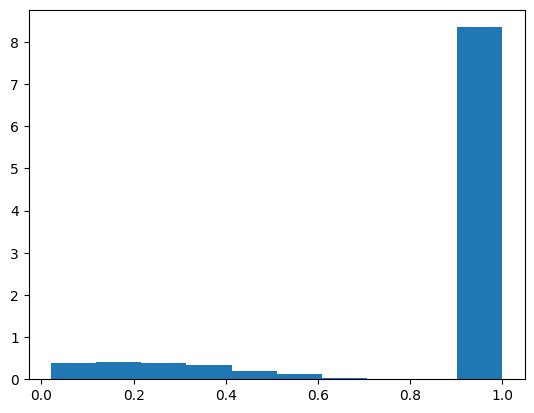

In [200]:
y = mean_magnetizations[0, :].cpu()
print(len(y), torch.mean(y))
plt.hist(y, density=True)
plt.show()

Many of the simulations did converge, but the rest is still enough to drag the average value of M down to a dissapointing value of 0.8651. Indeed, if we simulate this way, we will face this problem for all values of tempearture below Tc. I tried running this for arr_size = 32, n_sims = 300, n_steps = 10000, and plotted of the average value of M for all simulations. Here is the result

![alt text](image.png)
![alt text](image-4.png)

The region T > Tc seems to have no problem converging, which makes sense since the starting configuration is almost identical to the equilibrium configuration in this region. After a lot of testings, I came up with some rough estimates that for N = 32, we need to run at least 60,000 steps to reduce the rate of our simulation not converging to 1%. If we go all the way to 100,000, this rate will go down to ~0.3% (though this was a rough estimate of one of the test runs, so it might not be that accurate). We can try showing this

In [201]:
test_lattices = create_lattices(32, 300, 1)
temperatures = torch.linspace(1, 1, 1)
energies, magnetizations = metropolis(test_lattices, temperatures, 100000)
energies.shape, magnetizations.shape

Loading...: 100%|██████████| 100000/100000 [04:38<00:00, 358.92it/s]


(torch.Size([100000, 1, 300]), torch.Size([100000, 1, 300]))

In [202]:
mean_magnetizations = torch.mean(magnetizations[-1000:, ...], dim=0)
mean_magnetizations.shape

torch.Size([1, 300])

Number of simulations: 300
Average: 0.999285876750946


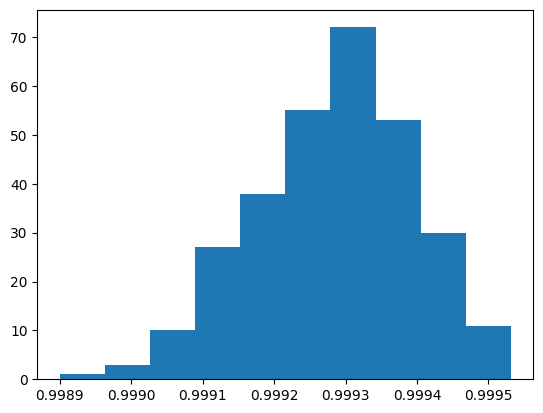

In [203]:
y = mean_magnetizations[0, :].cpu()
print(f"Number of simulations: {len(y)}\nAverage: {torch.mean(y)}")
plt.hist(y)
plt.show()

This is quite a sucess. Our simulation drops to 4-5 minutes per one point of temperature (using Project's 3 code, it took me roughly half an hour per point of temperature). However, the fact that we had to run a much larger number of steps is still unsatisfying. If we can somehow reduce this number, our code would run much faster.

I saw one workaround, which was to use only two simulations, but make the starting lattice biased (75% spin up and 75% spin down). This will help we reach equilibrium much faster, since the starting state is somewhere inbetween the two extreme cases. We can try recreating this\
(Note: the original code did this for a lattice of N = 1000, bias = 0.75, and n_temps = 20, so I'm going to pick some similar numbers here to compare with that one)

In [6]:
def create_lattices_biased(arr_size, n_temps, bias):
	lattices = []
	for _ in range(n_temps):
		lattice = torch.rand((arr_size, arr_size), dtype=torch.float32)
		lattice[lattice >= bias] = 1
		lattice[lattice < bias] = -1
		lattices.append(lattice)
	return torch.stack(lattices).unsqueeze(dim=1).to(DEVICE)

N = 1024
n_temps = 50
bias = 0.75
up_lattice = create_lattices_biased(N, n_temps, bias)
down_lattice = create_lattices_biased(N, n_temps, 1-bias)

up_lattice.shape, down_lattice.shape

(torch.Size([50, 1, 1024, 1024]), torch.Size([50, 1, 1024, 1024]))

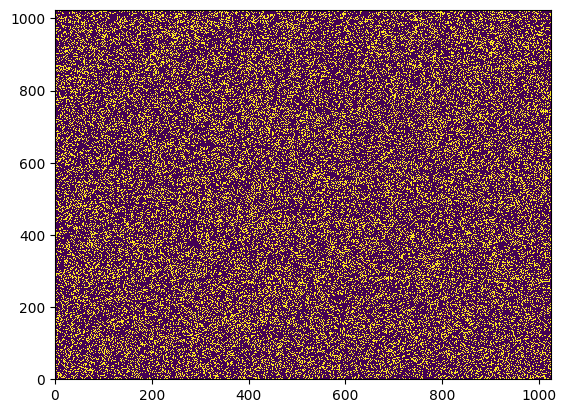

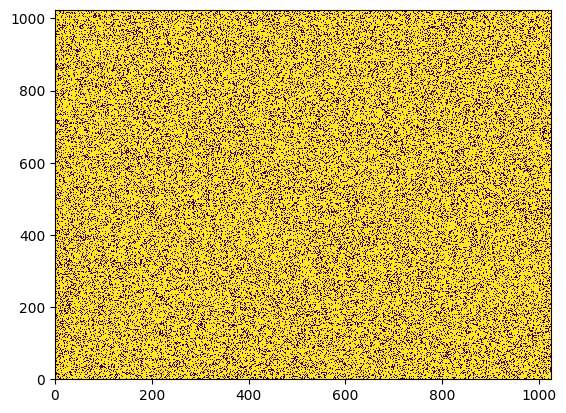

In [322]:
plt.pcolormesh(up_lattice[0, 0])
plt.show()
plt.pcolormesh(down_lattice[0, 0])
plt.show()

From here, we can use the code up there and run the simulation for each of the lattice

In [323]:
temps = torch.linspace(1, 3, n_temps)
energy_up, magnetization_up = metropolis(up_lattice, temps, 1000)
energy_down, magnetization_down = metropolis(down_lattice, temps, 1000)
energy_up.shape, magnetization_up.shape

Loading...: 100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s]


(torch.Size([1000, 50, 1]), torch.Size([1000, 50, 1]))

First, we can check if the simulation converges (for both the positive and negative one we plot for all temperatures)

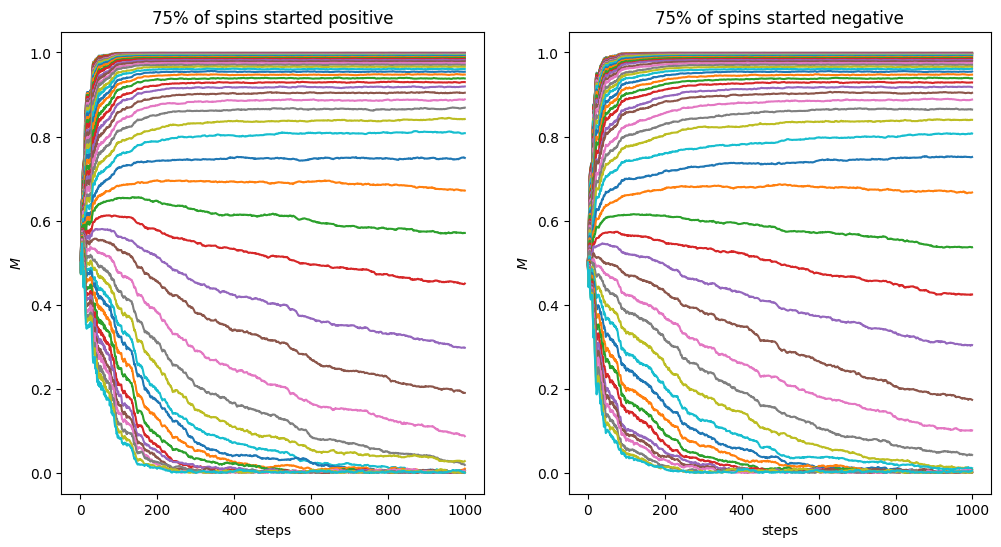

In [332]:
magnetization_up_simuls = magnetization_up[:, :, 0]
magnetization_down_simuls = magnetization_down[:, :, 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.xlabel("steps")
plt.ylabel("M")
for i in range(50):
    axes[0].plot(range(1000), magnetization_up_simuls[:, i])

for i in range(50):
    axes[1].plot(range(1000), magnetization_down_simuls[:, i])

axes[0].set_title("75% of spins started positive")
axes[0].set_xlabel("steps")
axes[0].set_ylabel(r"$M$")

axes[1].set_title("75% of spins started negative")
axes[1].set_xlabel("steps")
axes[1].set_ylabel(r"$M$")
plt.show()

We can see that if we start this way, most of the simulations ended up converging to some value (beside a few that are near Tc). We can continue to plot for E, M, C, X as a function of T.

In [333]:
mean_energy_up = torch.mean(energy_up[-400:], dim=0).squeeze(dim=-1)
mean_magnetization_up = torch.mean(magnetization_up[-400:], dim=0).squeeze(dim=-1)
mean_energy_down = torch.mean(energy_down[-400:], dim=0).squeeze(dim=-1)
mean_magnetization_down = torch.mean(magnetization_down[-400:], dim=0).squeeze(dim=-1)

In [334]:
mean_energy_up.shape

torch.Size([50])

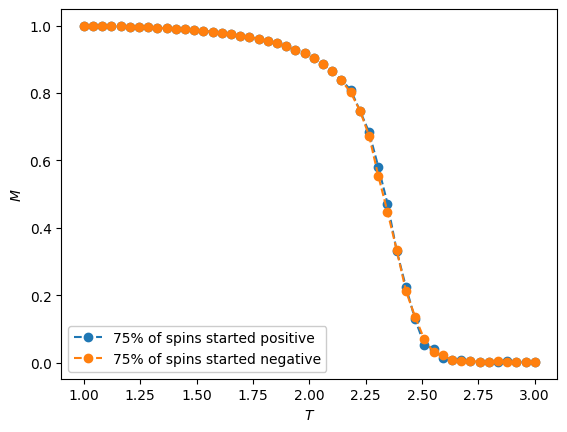

In [336]:
plt.plot(temps, mean_magnetization_up, 'o--', label='75% of spins started positive')
plt.plot(temps, mean_magnetization_down, 'o--', label='75% of spins started negative')
plt.xlabel(r"$T$")
plt.ylabel(r"$M$")
plt.legend(facecolor='white', framealpha=1)
plt.show()

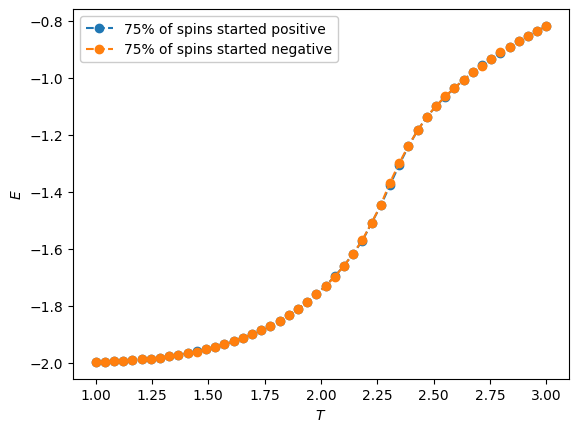

In [337]:
plt.plot(temps, mean_energy_up, 'o--', label='75% of spins started positive')
plt.plot(temps, mean_energy_down, 'o--', label='75% of spins started negative')
plt.xlabel(r"$T$")
plt.ylabel(r"$E$")
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [338]:
heat_capacity_up = torch.var(energy_up[-400:], dim=0).squeeze(dim=-1) / temps**2
heat_capacity_down = torch.var(energy_down[-400:], dim=0).squeeze(dim=-1) / temps**2

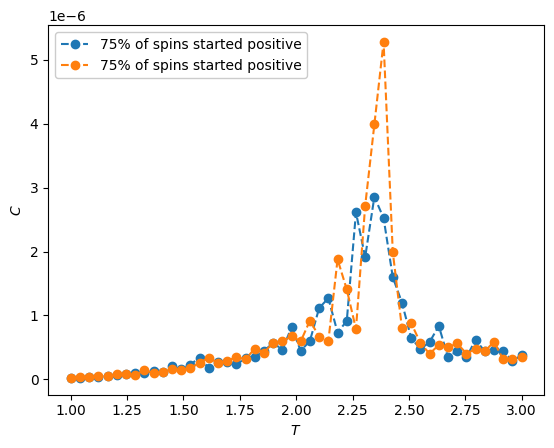

In [339]:
plt.plot(temps, heat_capacity_up, 'o--', label='75% of spins started positive')
plt.plot(temps, heat_capacity_down, 'o--', label='75% of spins started positive')
plt.xlabel(r"$T$")
plt.ylabel(r"$C$")
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [340]:
mag_sus_up = torch.var(magnetization_up[-400:], dim=0).squeeze(dim=-1) / temps
mag_sus_down = torch.var(magnetization_down[-400:], dim=0).squeeze(dim=-1) / temps

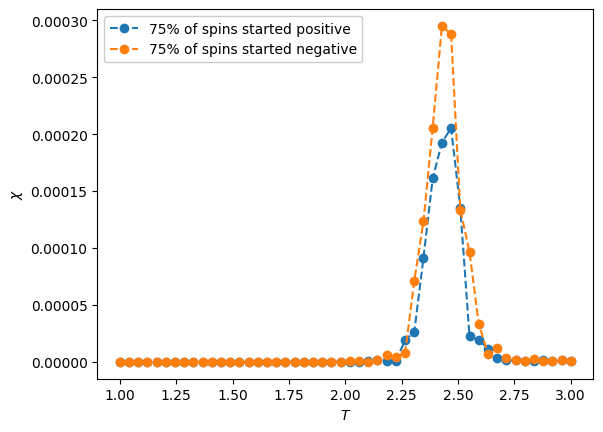

In [341]:
plt.plot(temps, mag_sus_up, 'o--', label='75% of spins started positive')
plt.plot(temps, mag_sus_down, 'o--', label='75% of spins started negative')
plt.xlabel(r"$T$")
plt.ylabel(r"$\chi$")
plt.legend(facecolor='white', framealpha=1)
plt.show()

The plot for C and X somewhat had a peak around Tc as expected. The figure obtained here is also similar to the one in the original code (shown below)
![alt text](image-1.png)
![alt text](image-2.png)
![alt text](image-3.png)

Considering that it only took us 10 minutes to run the simulation for an array size of 1024 x 1024, this is quite good.

Another approach to this was to change the probabilities of flipping, which was suggested in this handout https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf. The author suggested that modify it by multiplying 0.1 to the transition probability. The code in the handout is shown below\
\
transitions = (rand(N) < p_trans).*(rand(N) < 0.1) * -2 + 1


which means that for a transition to occur, the random value generated from rand(N) must be smaller than the the transition probability, and another value generated from rand(N) must be smaller than 0.1. In the handout, the author considered flipping all the elements at the same time; we will try doing this

In [7]:
def metropolis_modified(lattices, temperatures, n_steps):
	"""
	Do the metropolis algorithm.
	Return the energies and the magnetization of each step
	"""
	arr_size, n_sims = lattices.shape[-1], lattices.shape[1]
	energies = []
	magnetizations = []
	betas = (
        torch.vstack([1 / temperatures for _ in range(n_sims)]).T
    ).reshape([-1, n_sims, 1, 1]).to(DEVICE)

	for _ in tqdm(range(n_steps), desc="Loading..."):
		i = np.random.randint(0, 2)
		j = np.random.randint(0, 2)
		energy_arr = create_energy_arr(lattices)
		energies.append(energy_arr.sum(axis=(2, 3)) / 2 / arr_size**2)
		magnetizations.append(torch.abs(lattices.sum(axis=(2, 3))) / arr_size**2)
		delta_E = -2 * energy_arr
		probs = torch.exp(-betas * delta_E)
		probs[probs > 1] = 1
		flip_arr = torch.rand(delta_E.shape).to(DEVICE) < (probs * 0.1)
		lattices[..., i::1, j::1][flip_arr[..., i::1, j::1]] *= -1
	return torch.stack(energies), torch.stack(magnetizations)

In [368]:
test_lattices = create_lattices(32, 197, 28)
temperatures = torch.linspace(1.5, 3.5, 28)
energies, magnetizations = metropolis_modified(test_lattices, temperatures, 10000)
energies.shape, magnetizations.shape

Loading...: 100%|██████████| 10000/10000 [08:20<00:00, 19.98it/s]


(torch.Size([10000, 28, 197]), torch.Size([10000, 28, 197]))

In [369]:
mean_magnetizations_onetemp = torch.mean(magnetizations[-200:, ...], dim=0)
mean_magnetizations_onetemp.shape

torch.Size([28, 197])

197 tensor(0.8416)


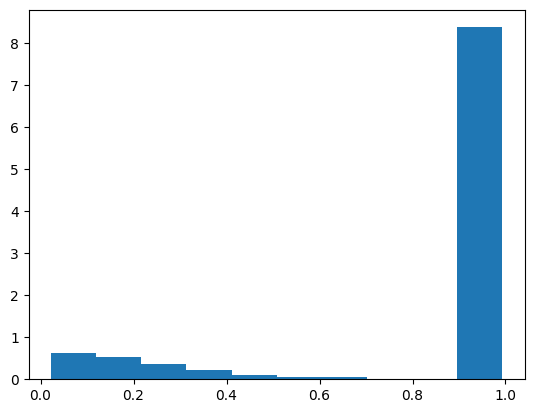

In [406]:
y = mean_magnetizations_onetemp[0, :].cpu()
print(len(y), torch.mean(y))
plt.hist(y, density=True)
plt.show()

In [374]:
all_e_val = torch.mean(energies[-2000:], dim=0).view(-1)
all_m_val = torch.mean(magnetizations[-2000:], dim=0).view(-1)
all_t_val = torch.stack([temperatures for _ in range(197)]).T.reshape(-1)
all_e_val.shape, all_m_val.shape, all_t_val.shape

(torch.Size([5516]), torch.Size([5516]), torch.Size([5516]))

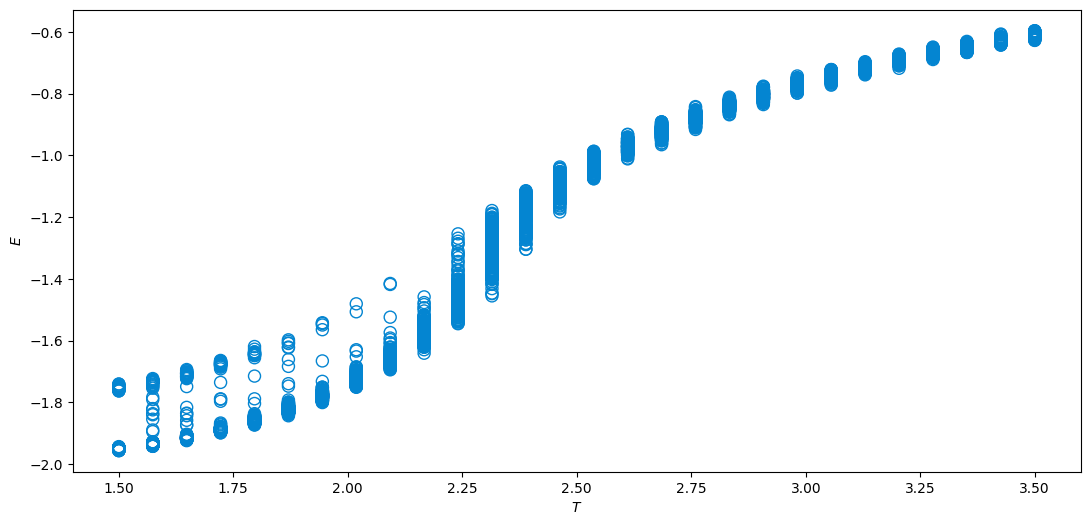

In [400]:
fig = plt.figure(figsize=(13, 6))
plt.scatter(all_t_val, all_e_val, s=75, facecolors='none', edgecolors='xkcd:cerulean')
plt.xlabel(r"$T$")
plt.ylabel(r"$E$")
plt.show()

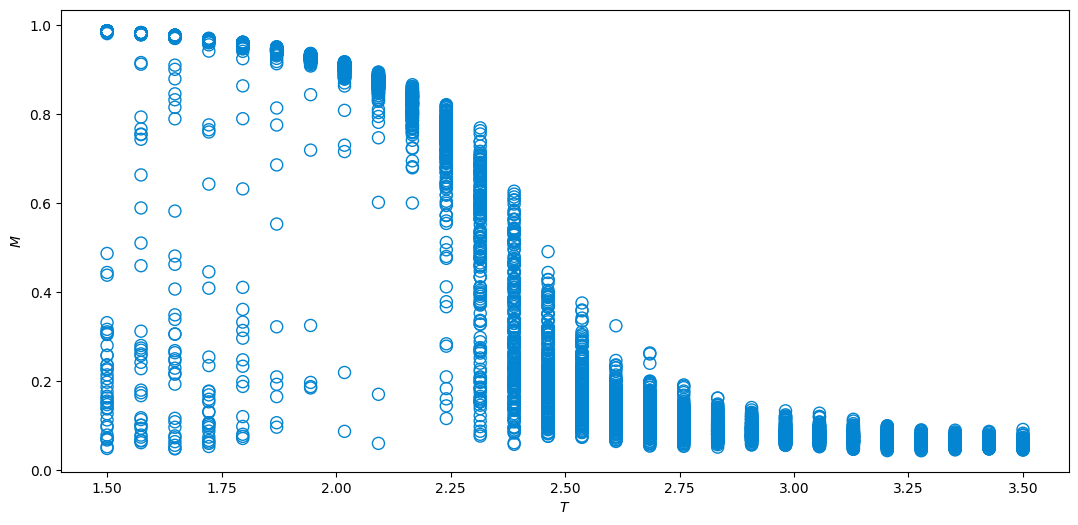

In [399]:
fig = plt.figure(figsize=(13, 6))
plt.scatter(all_t_val, all_m_val, s=75, facecolors='none', edgecolors='xkcd:cerulean')
plt.xlabel(r"$T$")
plt.ylabel(r"$M$")
plt.show()

This is similar to what the author got in the handout. The difference between this and the one that we did above is that for this one the simulation will either stay near the M = 0 state or the M = 1 state, and less in the region inbetween (0.4 < M < 1). As written in the handout, this is due to simulations staying in metastable states (forming chucks of similiar spins). The figures from the handouts are shown below.

![alt text](image-8.png)
![alt text](image-9.png)
![alt text](image-10.png)

Since there is still a problem with the region T < Tc, the heat capacity and the magnetic susceptibility in that region will not be accurate. Nevertheless, we can still see a phase transition around Tc

In [403]:
heat_capacity = torch.var(energies[-2000:], dim=(0, 2)) / temperatures**2
mag_sus = torch.var(magnetizations[-2000:], dim=(0, 2)) / temperatures

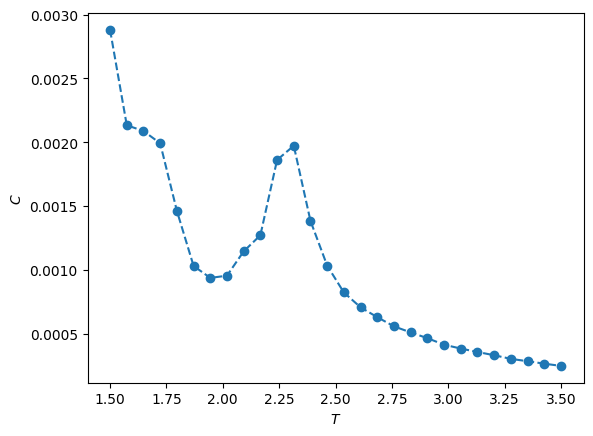

In [409]:
plt.plot(temperatures, heat_capacity, 'o--')
plt.xlabel(r"$T$")
plt.ylabel(r"$C$")
plt.show()

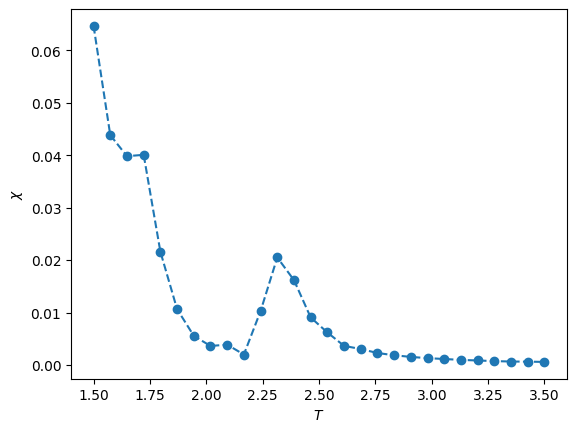

In [411]:
plt.plot(temperatures, mag_sus, 'o--')
plt.xlabel(r"$T$")
plt.ylabel(r"$\chi$")
plt.show()

Again, the simulation took about 8 miutes (n_sim = 197, n_temp = 28, n_steps = 10000), which is quite good.

#### b. Flipping one cell at a time


The problem with the region T < Tc might have something to the fact that we are flipping many cells at once. Therefore, we might try flipping only one cell at a time, but still running multiple simulations simultaneously to see if there is still a speed benefit. However, if we only do one cell at a time, it would be very costly to calculate the energy array every step. We can create a function to manually update the energy array instead.

In [8]:
def get_neighbour_wrapped(row, col, arr_size):
    """
    Return neighbours
    """
    return [
        ((row - 1) % arr_size, col), ((row + 1) % arr_size, col),
        (row, (col - 1) % arr_size), (row, (col + 1) % arr_size)
	]

def update_energy_arr(lattices, energy_arr, flip_arr, row, col):
	arr_size = energy_arr.shape[-1]
	energy_arr[..., row, col][flip_arr] *= -1
	for i, j in get_neighbour_wrapped(row, col, arr_size):
		energy_arr[..., i, j][flip_arr] += -2 * (-lattices[..., i, j][flip_arr] * lattices[..., row, col][flip_arr])

In [9]:
def metropolis_one_cell(lattices, temperatures, n_steps):
	"""
	Do the metropolis algorithm.
	Return the energies and the magnetization of each step
	"""
	arr_size, n_sims = lattices.shape[-1], lattices.shape[1]
	energies = []
	magnetizations = []
	betas = (
        torch.vstack([1 / temperatures for _ in range(n_sims)]).T
    ).to(DEVICE)
	energy_arr = create_energy_arr(lattices)
	energies.append(energy_arr.sum(axis=(2, 3)) / 2 / arr_size**2)
	magnetizations.append(lattices.sum(axis=(2, 3)) / arr_size**2)

	for _ in tqdm(range(n_steps), desc="Loading..."):
		i = np.random.randint(0, arr_size)
		j = np.random.randint(0, arr_size)
		delta_E = -2 * energy_arr[..., i, j]
		delta_M = -2 * lattices[..., i, j]
		probs = torch.exp(-betas * delta_E)
		flip_arr = torch.rand(delta_E.shape).to(DEVICE) < probs
		update_energy_arr(lattices, energy_arr, flip_arr, i, j)
		lattices[..., i, j][flip_arr] *= -1
		last_energies = energies[-1]
		last_magnetizations = magnetizations[-1]
		new_energies = last_energies + delta_E * flip_arr / arr_size**2
		new_magnetizations = last_magnetizations + delta_M * flip_arr / arr_size**2
		energies.append(new_energies)
		magnetizations.append(new_magnetizations)
	return torch.stack(energies), torch.stack(magnetizations)

In [10]:
new_all_energies = []
new_all_magnetizations = []
new_all_temperatures = []
for i in range(4):
	new_test_lattices = create_lattices(32, 300, 10)
	new_temperatures = torch.linspace(1.5 + 0.5*i, 2 + 0.5*i, 10)
	new_all_temperatures.append(new_temperatures)
	new_energies, new_magnetizations = metropolis_one_cell(new_test_lattices, new_temperatures, 500_000)
	new_all_energies.append(new_energies)
	new_all_magnetizations.append(new_magnetizations)

Loading...: 100%|██████████| 500000/500000 [06:29<00:00, 1283.31it/s]


In [11]:
new_mean_magnetizations = torch.vstack(
    [torch.mean(x[-250_000:, ...], dim=0) for x in new_all_magnetizations]
)
new_mean_magnetizations.shape

torch.Size([40, 300])

Number of simulations: 300
Average: -0.016731109470129013


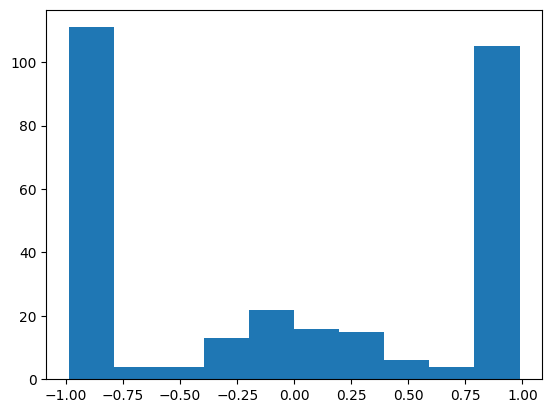

In [12]:
new_y = new_mean_magnetizations[0, :].cpu()
print(f"Number of simulations: {len(new_y)}\nAverage: {torch.mean(new_y)}")
plt.hist(new_y)
plt.show()

In [13]:
new_all_e_val = torch.vstack([torch.mean(e[-250_000:], dim=0) for e in new_all_energies]).reshape(-1)
new_all_m_val = torch.vstack([torch.mean(m[-250_000:], dim=0) for m in new_all_magnetizations]).reshape(-1)
new_all_t_val = torch.vstack([
    torch.stack([x for _ in range(300)]).T.reshape(-1) for x in new_all_temperatures
]).reshape(-1)
new_all_e_val.shape, new_all_m_val.shape, new_all_t_val.shape

(torch.Size([12000]), torch.Size([12000]), torch.Size([12000]))

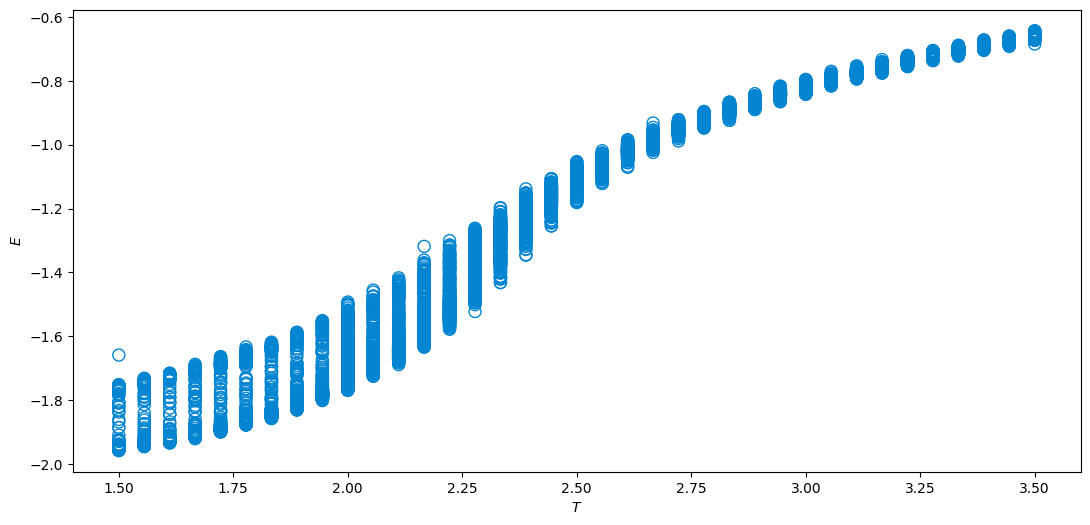

In [14]:
fig = plt.figure(figsize=(13, 6))
plt.scatter(new_all_t_val, new_all_e_val, s=75, facecolors='none', edgecolors='xkcd:cerulean')
plt.xlabel(r"$T$")
plt.ylabel(r"$E$")
plt.show()

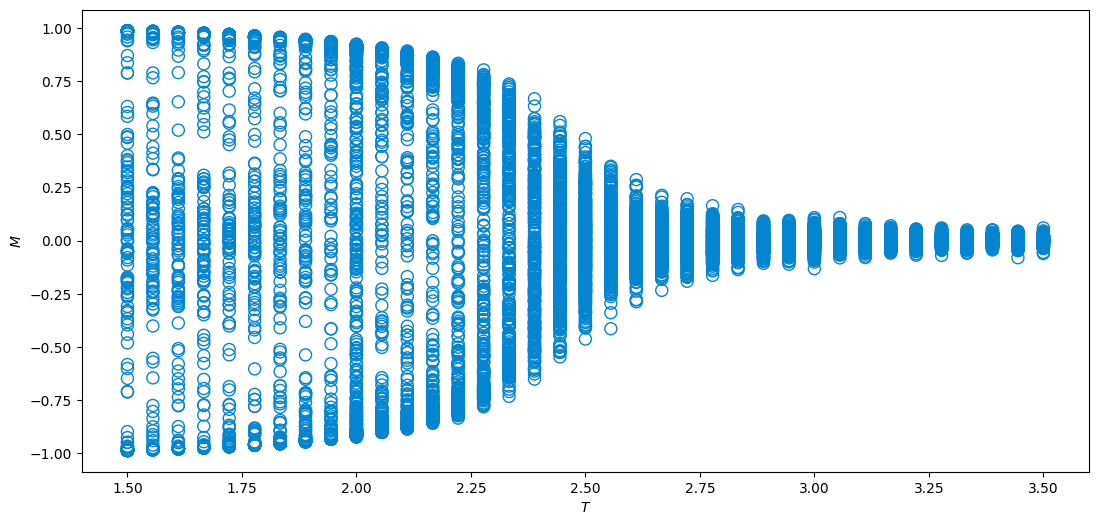

In [20]:
fig = plt.figure(figsize=(13, 6))
plt.scatter(new_all_t_val, new_all_m_val, s=75, facecolors='none', edgecolors='xkcd:cerulean')
plt.xlabel(r"$T$")
plt.ylabel(r"$M$")
plt.show()

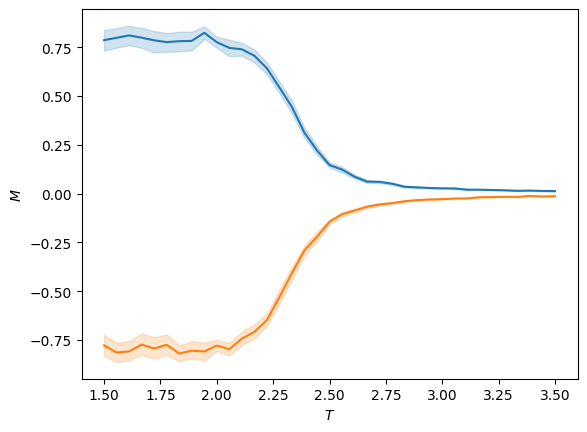

In [15]:
sns.lineplot(x=new_all_t_val[new_all_m_val > 0], y=new_all_m_val[new_all_m_val > 0])
sns.lineplot(x=new_all_t_val[new_all_m_val < 0], y=new_all_m_val[new_all_m_val < 0])
plt.xlabel(r"$T$")
plt.ylabel(r"$M$")
plt.show()

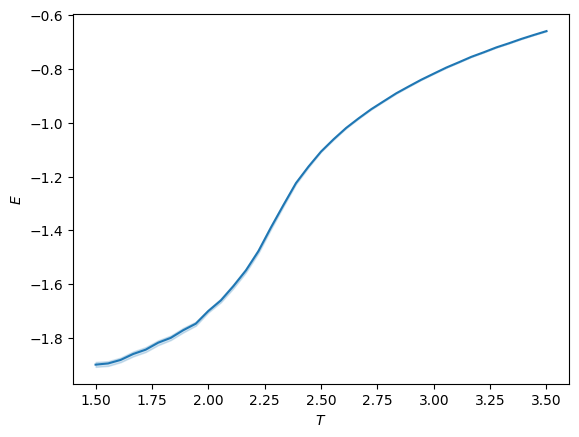

In [16]:
sns.lineplot(x=new_all_t_val, y=new_all_e_val)
plt.xlabel(r"$T$")
plt.ylabel(r"$E$")
plt.show()

In [17]:
new_all_c_val = torch.vstack([torch.var(e[-250_000:], dim=0) for e in new_all_energies]).reshape(-1) / new_all_t_val**2
new_all_x_val = torch.vstack([torch.var(m[-250_000:], dim=0) for m in new_all_magnetizations]).reshape(-1) / new_all_t_val
new_all_c_val.shape, new_all_x_val.shape, new_all_t_val.shape

(torch.Size([12000]), torch.Size([12000]), torch.Size([12000]))

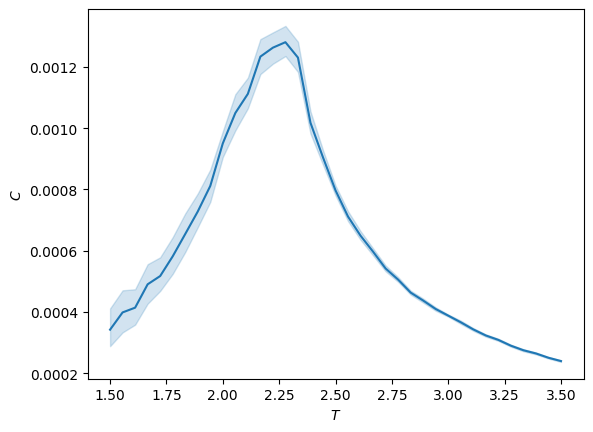

In [18]:
sns.lineplot(x=new_all_t_val, y=new_all_c_val)
plt.xlabel(r"$T$")
plt.ylabel(r"$C$")
plt.show()

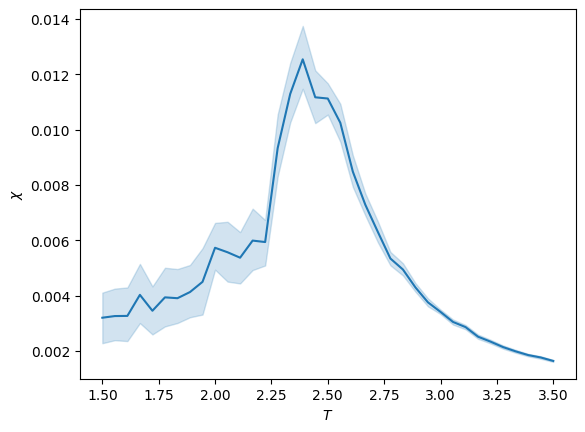

In [19]:
sns.lineplot(x=new_all_t_val, y=new_all_x_val)
plt.xlabel(r"$T$")
plt.ylabel(r"$\chi$")
plt.show()

Considering that the entire thing took 20 minutes to run, this is quite good! We can see a clear phase transition around Tc.

## III. Putting everything together into a class
Next, let's put everything together into a class. I'll create two class, MultiCell for part a), and UniCell for part b). The Simulation class shares the similar methods of the two classes.

In [3]:
class Simulation:
	"""
	Creates a 2D Ising Simulation
	"""
	def __init__(self, arr_size: int, temps: torch.Tensor, n_sims: int, n_steps: int):
		"""
		Parameters:
			- arr_size (int): the size of our Ising array.
			- temp (torch.Tensor): the values of the temperatures
			- n_sims (int): the number of simulations at each temperature)
			- n_steps (int): the number of step of each simulation
		"""
		self.size = arr_size
		self.temps = temps
		self.ntemps = len(temps)
		self.nsims = n_sims
		self.nsteps = n_steps

	def create_lattices(self) -> torch.Tensor:
		"""
		This will create an array with 1 and -1 of the following shape
			[self.ntemps, self.nsims, self.size, self.size]

		This is the initial lattices of our simulation.
		"""
		return torch.stack([
			torch.stack([
				torch.randint(low=0, high=2, size=(self.size, self.size), dtype=torch.float32) * 2 - 1
				for _ in range(self.nsims)
			])
			for _ in range(self.ntemps)
		]).to(DEVICE)

	def create_energy_arr(self, lattices: torch.Tensor) -> torch.Tensor:
		"""
		This will create an array of the interaction energy of each magnet with its neighbour for all lattices. Its shape will be
			[n_temps, n_sims, arr_size, arr_size]
		"""
		# To do this, we create a kernel and do the convolution.
		kernel = torch.tensor(
			[[0, 1, 0],
			 [1, 0, 1],
			 [0, 1, 0]], dtype=torch.float32
		).unsqueeze(dim=0).unsqueeze(dim=0).to(DEVICE)
		# To convolve, we need to reshape our lattices array into [n_temps * n_sims, 1, arr_size, arr_size]
		reshape_lattices = lattices.view(-1, 1, self.size, self.size)
		energy_arr = -reshape_lattices * conv2d(pad(reshape_lattices, pad=(1, 1, 1, 1), mode='circular'), kernel)
		# After that, we convert it back into the original shape
		return energy_arr.view(lattices.shape)

	def statistics(self, energies: torch.Tensor, magnetizations: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
		"""
		Given the energies and the magnetizations (result that we get after running metropolis), returns all value of E, M, C, X, T.
		"""
		num_vals = int(self.nsteps * 0.4)
		all_e_val = torch.mean(energies[-num_vals:], dim=0).view(-1)
		all_m_val = torch.mean(magnetizations[-num_vals:], dim=0).view(-1)
		all_t_val = torch.stack([self.temps for _ in range(self.nsims)]).T.reshape(-1)
		all_c_val = torch.var(energies[-num_vals:], dim=0).view(-1) / all_t_val**2
		all_x_val = torch.var(magnetizations[-num_vals:], dim=0).view(-1) / all_t_val**2
		return (
			all_e_val, all_m_val,
			all_c_val, all_x_val,
			all_t_val
		)


class MultiCell(Simulation):
	"""
	Simulation where we flip cells in a checkerboard pattern
	Typical value of steps: 10_000 to 100_000
	"""
	def metropolis(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
		"""
		Do the metropolis algorithm.
		Return the final lattices + the energies and the magnetization of each step
		"""
		lattices = self.create_lattices()
		energies = []
		magnetizations = []
		betas = (
			torch.vstack([1 / self.temps for _ in range(self.nsims)]).T
		).reshape([-1, self.nsims, 1, 1]).to(DEVICE)

		for _ in tqdm(range(self.nsteps), desc="Loading..."):
			i = np.random.randint(0, 2)
			j = np.random.randint(0, 2)
			energy_arr = self.create_energy_arr(lattices)
			energies.append(energy_arr.sum(axis=(2, 3)) / 2 / self.size**2)             # type: ignore
			magnetizations.append(torch.abs(lattices.sum(axis=(2, 3))) / self.size**2)  # type: ignore
			delta_E = -2 * energy_arr
			probs = torch.exp(-betas * delta_E)
			flip_arr = (delta_E > 0) * (torch.rand(delta_E.shape).to(DEVICE) < probs) + (delta_E <= 0)
			lattices[..., i::2, j::2][flip_arr[..., i::2, j::2]] *= -1
		return lattices, torch.stack(energies), torch.stack(magnetizations)


class UniCell(Simulation):
	"""
	Simulation where we flip cells one by one.
	Typical value of steps: N^2 * 500 to N^2 * 1000
	"""
	def get_neighbour_wrapped(self, row: int, col: int) -> list[tuple[int, int]]:
		"""
		Return neighbours
		"""
		return [
			((row - 1) % self.size, col), ((row + 1) % self.size, col),
			(row, (col - 1) % self.size), (row, (col + 1) % self.size)
		]

	def update_energy_arr(self, lattices: torch.Tensor, flip_arr: torch.Tensor, row: int, col: int) -> None:
		"""
		Updates the energy array.
		"""
		energy_arr[..., row, col][flip_arr] *= -1
		for i, j in get_neighbour_wrapped(row, col, self.size):
			energy_arr[..., i, j][flip_arr] += -2 * (-lattices[..., i, j][flip_arr] * lattices[..., row, col][flip_arr])

	def metropolis(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
		"""
		Do the metropolis algorithm.
		Return the final lattices + the energies and the magnetization of each step
		"""
		lattices = self.create_lattices()
		energies = []
		magnetizations = []
		betas = (
			torch.vstack([1 / self.temps for _ in range(self.nsims)]).T
		).to(DEVICE)
		energy_arr = self.create_energy_arr(lattices)
		energies.append(energy_arr.sum(axis=(2, 3)) / 2 / self.size**2)  # type: ignore
		magnetizations.append(lattices.sum(axis=(2, 3)) / self.size**2)  # type: ignore

		for _ in tqdm(range(self.nsteps), desc="Loading..."):
			i = np.random.randint(0, self.size)
			j = np.random.randint(0, self.size)
			delta_E = -2 * energy_arr[..., i, j]
			delta_M = -2 * lattices[..., i, j]
			probs = torch.exp(-betas * delta_E)
			flip_arr = torch.rand(delta_E.shape).to(DEVICE) < probs
			update_energy_arr(lattices, energy_arr, flip_arr, i, j)
			lattices[..., i, j][flip_arr] *= -1
			last_energies = energies[-1]
			last_magnetizations = magnetizations[-1]
			new_energies = last_energies + delta_E * flip_arr / self.size**2
			new_magnetizations = last_magnetizations + delta_M * flip_arr / self.size**2
			energies.append(new_energies)
			magnetizations.append(new_magnetizations)
		return lattices, torch.stack(energies), torch.stack(magnetizations)


We might also define some useful functions.

In [4]:
def show_lattice(lattice: torch.Tensor) -> None:
    plt.figure(figsize=(8, 8))
    plt.imshow(lattice)
    plt.show()


def plot_vs_temp(temp: torch.Tensor, val: torch.Tensor, ylabel: str) -> None:
    sns.lineplot(x=temp, y=val)
    plt.xlabel(r"$T$")
    plt.ylabel(ylabel)
    plt.grid()
    plt.show()

Let's test the simulation

In [143]:
test_simul_multi = MultiCell(
    arr_size = 32,
    temps = torch.linspace(1.5, 3.5, 20),
    n_sims = 100,
    n_steps = 10_000
)

In [144]:
mul_l, mul_e, mul_m = test_simul_multi.metropolis()

Loading...: 100%|██████████| 10000/10000 [03:41<00:00, 45.18it/s]


In [145]:
mul_all_e, mul_all_m, mul_all_c, mul_all_x, mul_all_t = test_simul_multi.statistics(mul_e, mul_m)

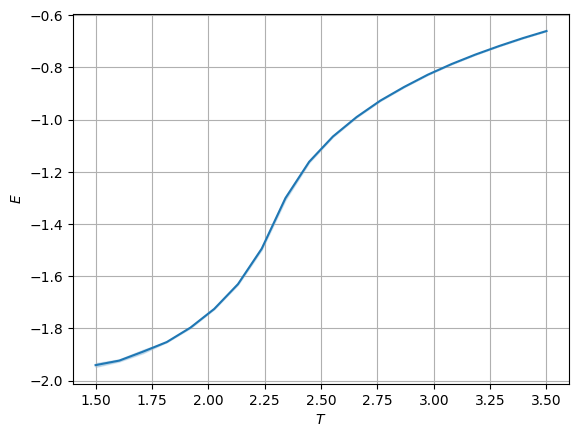

In [172]:
plot_vs_temp(mul_all_t, mul_all_e, r"$E$")

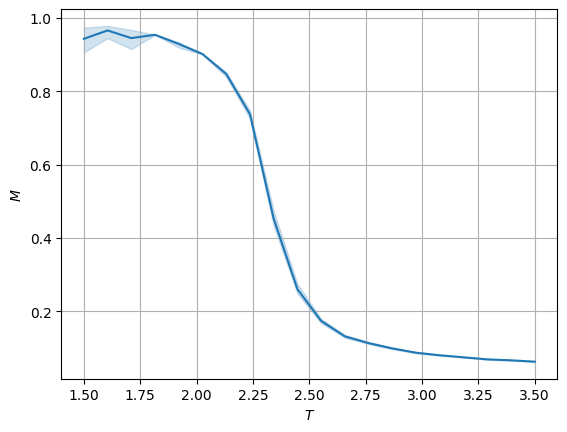

In [173]:
plot_vs_temp(mul_all_t, mul_all_m, r"$M$")

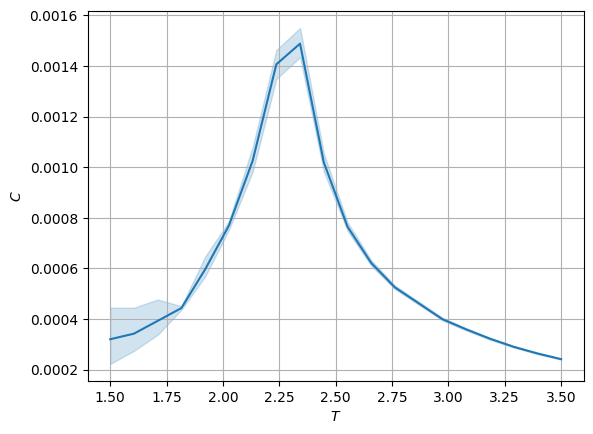

In [162]:
plot_vs_temp(mul_all_t, mul_all_c, r"$C$")

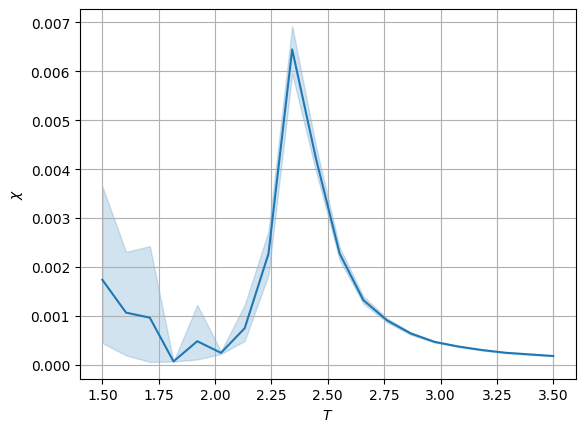

In [163]:
plot_vs_temp(mul_all_t, mul_all_x, r"$\chi$")

In [164]:
test_simul_uni = UniCell(
    arr_size = 32,
    temps = torch.linspace(1.5, 3.5, 20),
    n_sims = 100,
    n_steps = 500_000
)

In [151]:
uni_l, uni_e, uni_m = test_simul_uni.metropolis()

Loading...: 100%|██████████| 500000/500000 [02:47<00:00, 2983.06it/s]


In [152]:
uni_all_e, uni_all_m, uni_all_c, uni_all_x, uni_all_t = test_simul_uni.statistics(uni_e, uni_m)

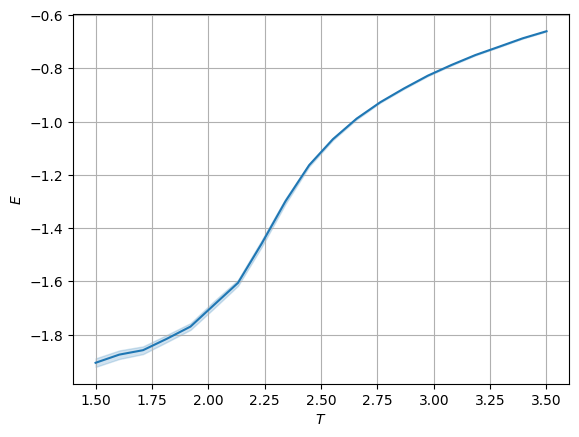

In [165]:
plot_vs_temp(uni_all_t, uni_all_e, r"$E$")

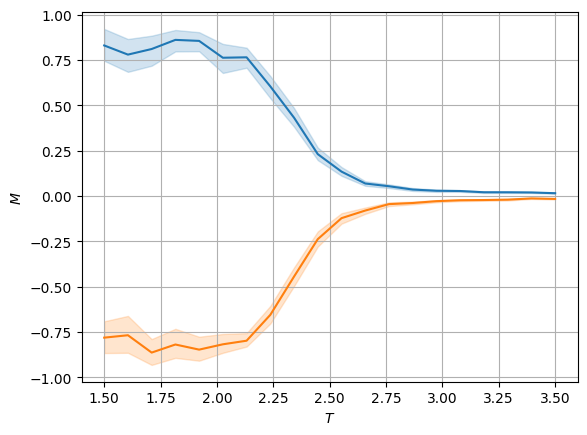

In [158]:
sns.lineplot(x=uni_all_t[uni_all_m > 0], y=uni_all_m[uni_all_m > 0])
sns.lineplot(x=uni_all_t[uni_all_m < 0], y=uni_all_m[uni_all_m < 0])
plt.xlabel(r"$T$")
plt.ylabel(r"$M$")
plt.grid()
plt.show()

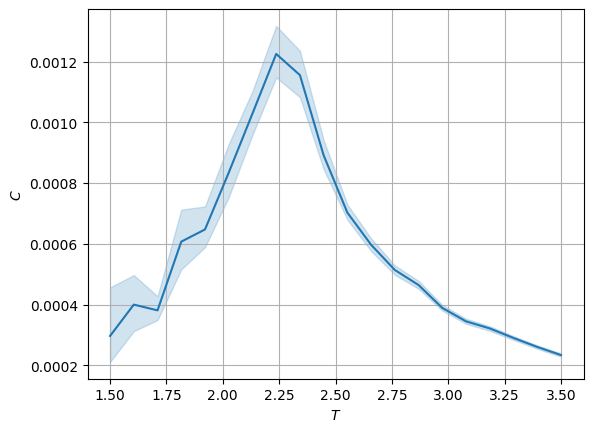

In [166]:
plot_vs_temp(uni_all_t, uni_all_c, r"$C$")

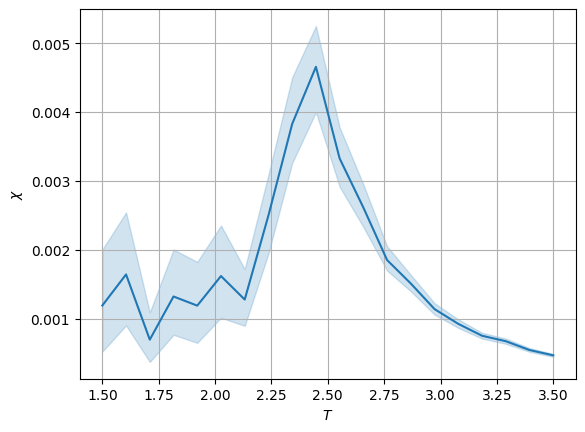

In [167]:
plot_vs_temp(uni_all_t, uni_all_x, r"$\chi$")

We can see that the result that we got is quite good for something that only took 4 minutes to run!

For the last test, let's try running MultiCell for arr_size = 32, 30 points of T, nsims = 300, nsteps = 50_000

In [5]:
test_final = MultiCell(
    arr_size = 32,
    temps = torch.linspace(1.5, 3.5, 50),
    n_sims = 250,
    n_steps = 50_000
)

In [6]:
_, e_final, m_final = test_final.metropolis()

Loading...:   0%|                         | 192/50000 [00:21<1:33:53,  8.84it/s]


KeyboardInterrupt: 

In [197]:
final_all_e, final_all_m, final_all_c, final_all_x, final_all_t = test_final.statistics(e_final, m_final)

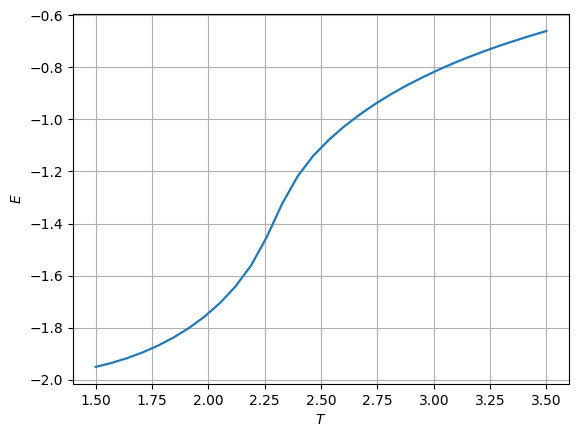

In [198]:
plot_vs_temp(final_all_t, final_all_e, r"$E$")

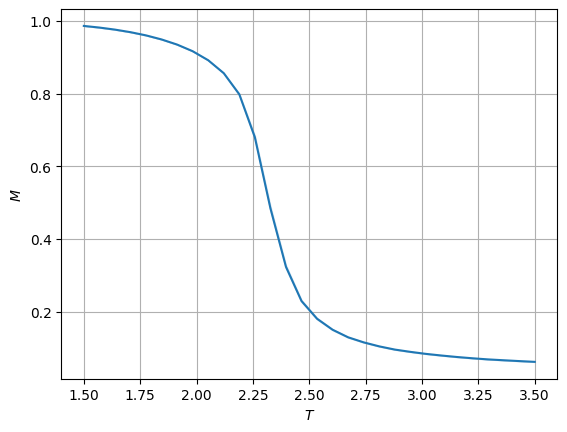

In [199]:
plot_vs_temp(final_all_t, final_all_m, r"$M$")

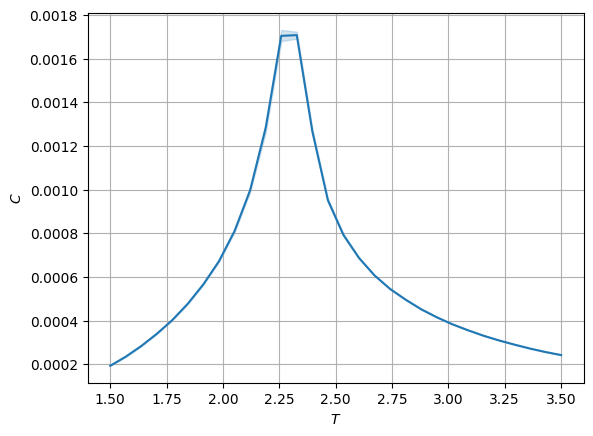

In [200]:
plot_vs_temp(final_all_t, final_all_c, r"$C$")

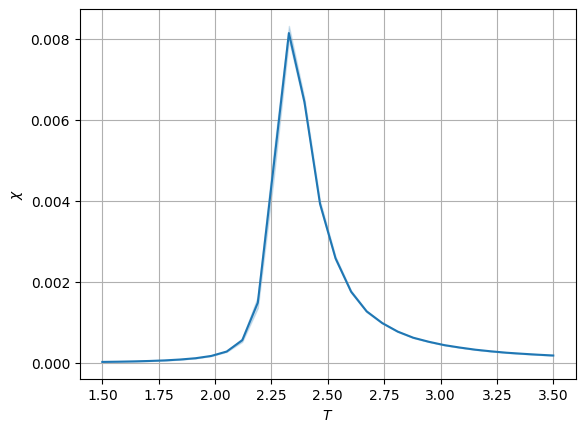

In [201]:
plot_vs_temp(final_all_t, final_all_x, r"$\chi$")

And this only took one hour!

## IV. Simulating near Tc
After speeding up our simulation, we might as well give this one a shot.

In [180]:
Tc = 2 / np.log(1 + 2**0.5)
Tc

2.269185314213022

In [189]:
uni_near_Tc = UniCell(
    arr_size = 128,
    temps = torch.linspace(Tc, Tc, 1),
    n_sims = 1,
    n_steps = 5_000_000
)
uni_lattice, _, _ = uni_near_Tc.metropolis()

Loading...: 100%|██████████| 5000000/5000000 [12:38<00:00, 6588.52it/s]


In [ ]:
multi_near_Tc = MultiCell(
    arr_size = 128,
    temps = torch.linspace(Tc, Tc, 1),
    n_sims = 1,
    n_steps = 1_000_000
)
multi_lattice, _, _ = multi_near_Tc.metropolis()

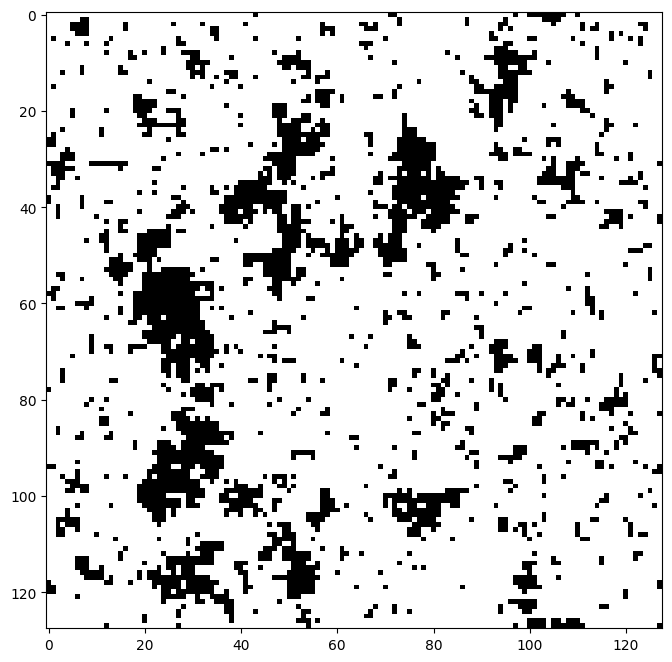

In [188]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(-multi_lattice[0][0], 'gray')

Well..., it probably did not work as well as we wanted it to. The metropolis algorithm has been known to do poorly near Tc, so simulating at this temperature is entirely another difficult problem.

## V. Conclusions
To summarize, we improved the simulation speed significantly using pytorch in this project. We recreated plots from the original sources, tested to see whether the simulations were good, and tried to optimize the parameters of the simulations. We ended up creating classes for two approaches to the simulation: flipping multiple cells (in a checkerboard pattern) and flipping one cell at a time. Both work reasonably well. We attempted to use this for near Tc simulation but were unsuccessful.


## VI. Reference

Mr. P. Solver - 10x Faster Than NumPy (GPU Magnet Simulation): https://youtu.be/ykoEwJ7PvNw?si=d0V7Ms7i9YZ2OEfp

University of Illinois Urbana-Champaign, Computing in Physics (498CMP): https://courses.physics.illinois.edu/phys498cmp/sp2022/Ising/IsingModel.html

Tobin Fricke - Monte Carlo investigation of the Ising model: https://www.asc.ohio-state.edu/braaten.1/statphys/Ising_MatLab.pdf